In [38]:
#!pip install xgboost
#!pip install imblearn

In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

## 1. Load & Preview Data

In [ ]:
# Load the CSV
df = pd.read_csv("../data/Telco_Customer_Churn_feature_engineered_v1.csv")

# Quick preview
df.head()

In [26]:
X = df.drop(columns=['customerID', 'Churn','Churn_num'])
y = df['Churn_num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## 2. Basic Model Training (Logistic, Decision Tree, Random Forest)

In [ ]:
#Restart
#Defining the Logistic Regression model
log_reg = LogisticRegression(max_iter=10000, random_state = 42)

# Grid of hyperparameters 
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1','l2'], 
    'solver': ['saga'],
    'class_weight': ['balanced']
}

# Grid Search with recall as the scoring metric because accuracy is not a good measure in imbalanced datasets and catching churn is the business case
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='recall', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("🔧 Best Parameters:", grid_search.best_params_)
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=["No Churn", "Churn"]))


🔧 Best Parameters: {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}

📊 Classification Report:
              precision    recall  f1-score   support

    No Churn       0.90      0.65      0.76      1035
       Churn       0.46      0.81      0.58       374

    accuracy                           0.69      1409
   macro avg       0.68      0.73      0.67      1409
weighted avg       0.79      0.69      0.71      1409



📉 Threshold set to: 0.34
              precision    recall  f1-score   support

    No Churn       0.95      0.48      0.64      1035
       Churn       0.40      0.94      0.56       374

    accuracy                           0.60      1409
   macro avg       0.68      0.71      0.60      1409
weighted avg       0.81      0.60      0.62      1409



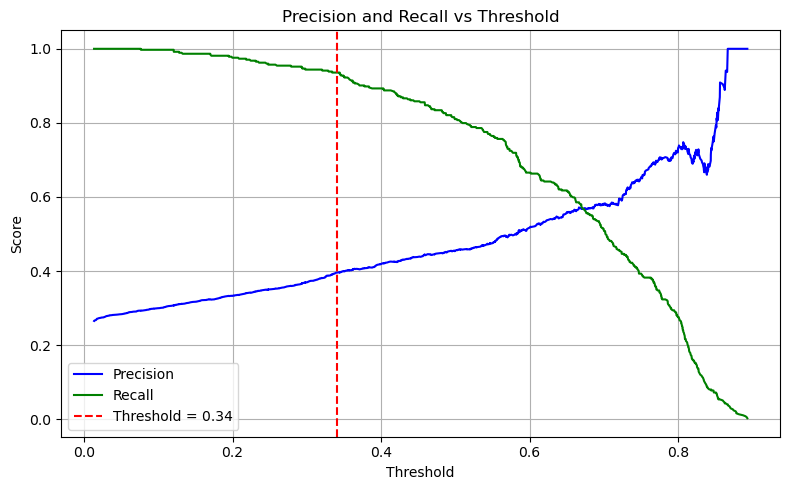

In [ ]:
# 1. Get predicted probabilities for the positive class (Churn = 1)
y_probs = best_model.predict_proba(X_test)[:, 1]

# 2. Set custom threshold
threshold = 0.34  #After reading the graph
y_pred_threshold = (y_probs >= threshold).astype(int)

# 3. Evaluate performance
print(f"📉 Threshold set to: {threshold}")
print(classification_report(y_test, y_pred_threshold, target_names=["No Churn", "Churn"]))

# 4. (Optional) Plot Precision-Recall vs. Threshold curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions[:-1], label='Precision', color='blue')
plt.plot(thresholds, recalls[:-1], label='Recall', color='green')
plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


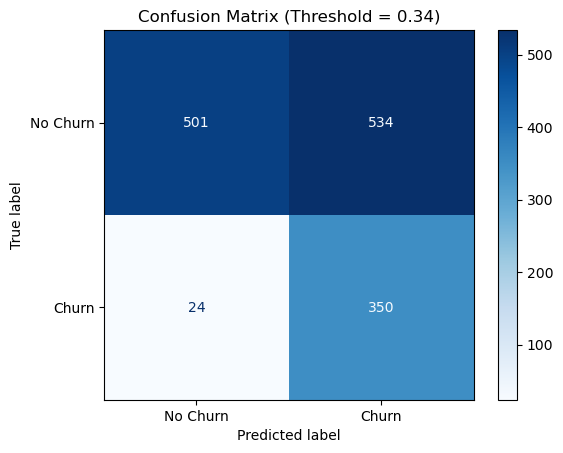

In [35]:
y_pred_thresh = (y_probs >= 0.34).astype(int)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_thresh)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Churn", "Churn"])

disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Threshold = 0.34)")
plt.grid(False)
plt.show()


In [ ]:
# 1. Apply SMOTE to training data only
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# 2. Re-train logistic regression on balanced data
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(
        penalty='l2',
        solver='liblinear',
        C=1.0,
        class_weight=None  # Turn off 'balanced' since we're using SMOTE now
    ))
])

pipeline.fit(X_train_sm, y_train_sm)

# 3. Predict probabilities on original test set
y_probs_sm = pipeline.predict_proba(X_test)[:, 1]


In [ ]:
#Start by checking the cell above

In [6]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

In [7]:
forest = RandomForestClassifier(n_estimators=100, random_state=42)
forest.fit(X_train, y_train)
y_pred_forest = forest.predict(X_test)

## 3. Model Evaluation

In [8]:
# Logistic Regression Evaluation:
def model_evalulation_metrics(y_pred):
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [9]:
print("Logistic Regression Metrics:")
model_evalulation_metrics(y_pred = y_pred_logreg)

Logistic Regression Metrics:
Accuracy: 0.8077
Precision: 0.6746
Recall: 0.5321
F1 Score: 0.5949

Confusion Matrix:
 [[939  96]
 [175 199]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.53      0.59       374

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409



In [10]:
# Decision Tree Evaluation:
print("Decision Tree Metrics:")
model_evalulation_metrics(y_pred = y_pred_tree)

Decision Tree Metrics:
Accuracy: 0.7360
Precision: 0.5026
Recall: 0.5134
F1 Score: 0.5079

Confusion Matrix:
 [[845 190]
 [182 192]]

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.82      0.82      1035
           1       0.50      0.51      0.51       374

    accuracy                           0.74      1409
   macro avg       0.66      0.66      0.66      1409
weighted avg       0.74      0.74      0.74      1409



In [11]:
# Random Forest Evaluation:
print("Random Forest Metrics:")
model_evalulation_metrics(y_pred = y_pred_forest)

Random Forest Metrics:
Accuracy: 0.7892
Precision: 0.6351
Recall: 0.4840
F1 Score: 0.5493

Confusion Matrix:
 [[931 104]
 [193 181]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      1035
           1       0.64      0.48      0.55       374

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.71      1409
weighted avg       0.78      0.79      0.78      1409



### 📌 Conclusion

Logistic Regression performed the strongest overall, reaching 81% accuracy.
However, all models show difficulty in catching churners (Recall around 50%), suggesting a need for further feature engineering or balancing techniques.

## 4. Parameter Tuning

In [12]:
# Define hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 10, 15, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['gini', 'entropy']  # Gini impurity or Information gain
}

# Setup the GridSearchCV
grid_search = GridSearchCV(tree, param_grid, cv=5, scoring='recall', n_jobs=-1)

# Fit to the training data
grid_search.fit(X_train, y_train)

# Best parameters
print(f"Best parameters: {grid_search.best_params_}")

# Best estimator
best_tree = grid_search.best_estimator_

# Predict and evaluate
y_pred_best_tree = best_tree.predict(X_test)


Best parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [13]:
# Decision Tree Evaluation:
print("Decision Tree Metrics:")
model_evalulation_metrics(y_pred = y_pred_best_tree)

Decision Tree Metrics:
Accuracy: 0.7509
Precision: 0.5273
Recall: 0.5936
F1 Score: 0.5585

Confusion Matrix:
 [[836 199]
 [152 222]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.81      0.83      1035
           1       0.53      0.59      0.56       374

    accuracy                           0.75      1409
   macro avg       0.69      0.70      0.69      1409
weighted avg       0.76      0.75      0.76      1409



### 📌 Conclusion

By optimising recall over accuracy we give up only 5% accuracy to increase recall by 30% to 59%, this means 59% of churn was identified correctly. As the opportunity cost of churn is much higher than the cost of action for someone who is not going to churn this is the right decision.

## 5. XGBoost Training

In [14]:
# GenAI scaffolding
xgb_model = xgb.XGBClassifier(
    n_estimators=100,      # number of trees
    learning_rate=0.1,     # step size shrinkage
    max_depth=5,           # max depth of a tree
    subsample=0.8,         # row sampling
    colsample_bytree=0.8,  # feature sampling
    random_state=42
)

# Fit model
xgb_model.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate

print("XGBoost Metrics:")
model_evalulation_metrics(y_pred = y_pred_xgb)

XGBoost Metrics:
Accuracy: 0.7970
Precision: 0.6447
Recall: 0.5241
F1 Score: 0.5782

Confusion Matrix:
 [[927 108]
 [178 196]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.64      0.52      0.58       374

    accuracy                           0.80      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409



In [15]:
y_probs = xgb_model.predict_proba(X_test)[:, 1]
y_pred_thresh = (y_probs >= 0.3).astype(int)  # changing the threshold to 30% because the cost of churn is much higher than the cost of a false alarm

In [16]:
print("XGBoost Metrics 30% threshold:")
model_evalulation_metrics(y_pred = y_pred_thresh)

XGBoost Metrics 30% threshold:
Accuracy: 0.7686
Precision: 0.5465
Recall: 0.7540
F1 Score: 0.6337

Confusion Matrix:
 [[801 234]
 [ 92 282]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.77      0.83      1035
           1       0.55      0.75      0.63       374

    accuracy                           0.77      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.77      0.78      1409



### 📌 Conclusion

Lowering the threshold has a great trade off because now the model catches 75% of the churners so 3 out of 4 while the accuracy is still around 77%. Next step is to improve precision with more parameter tuning

In [17]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}


In [18]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

grid_search = GridSearchCV(estimator=xgb_model,
                           param_grid=param_grid,
                           scoring='recall',
                           cv=5,
                           n_jobs=-1,
                           verbose=1)


In [19]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


c:\Users\tajbo\anaconda3\envs\datascience_base\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:06:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1]},
             scoring='recall', verbose=1)

In [20]:
best_xgb = grid_search.best_estimator_
y_pred_xgb_best = best_xgb.predict(X_test)

In [21]:
print("Best Parameters:", grid_search.best_params_)
model_evalulation_metrics(y_pred = y_pred_xgb_best)

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Accuracy: 0.7970
Precision: 0.6571
Recall: 0.4920
F1 Score: 0.5627

Confusion Matrix:
 [[939  96]
 [190 184]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.91      0.87      1035
           1       0.66      0.49      0.56       374

    accuracy                           0.80      1409
   macro avg       0.74      0.70      0.72      1409
weighted avg       0.79      0.80      0.79      1409



In [22]:
# Define the base model
xgb_aucpr = XGBClassifier(
    use_label_encoder=False,
    objective='binary:logistic',
    eval_metric='aucpr',  # This only affects the model training output
    random_state=42
)

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0]
}

# Wrap with GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_aucpr,
    param_grid=param_grid,
    scoring='average_precision',  # sklearn-compatible scoring for PR AUC
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Best model and parameters
best_model_aucpr = grid_search.best_estimator_
y_pred_xgb_aucpr_best = best_model_aucpr.predict(X_test)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


c:\Users\tajbo\anaconda3\envs\datascience_base\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:06:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [23]:
model_evalulation_metrics(y_pred = y_pred_xgb_aucpr_best)

Accuracy: 0.8041
Precision: 0.6750
Recall: 0.5053
F1 Score: 0.5780

Confusion Matrix:
 [[944  91]
 [185 189]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.68      0.51      0.58       374

    accuracy                           0.80      1409
   macro avg       0.76      0.71      0.73      1409
weighted avg       0.79      0.80      0.79      1409

